# AIM - 
The aim of the experiment is to study the DNA in human classify the seven different types of proteins that are common in humans using the protein sequence data using PyCaret.

# 1. Importing Libraries

In [77]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import seaborn as sns
sns.set_theme()
from matplotlib import cm 

In [78]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
# https://github.com/dkedar7/Install-Auto-Sklearn-on-Windows-and-MacOS
# https://chanmingman.wordpress.com/2022/12/19/enable-windows-subsystem-for-linux-in-windows-11/
# https://medium.com/@gracy.f/automl-for-python-on-windows-314ca8ea6955

#### failed to install auto-sklearn in Windows Environment, use Pycaret instead

In [80]:
#!pip3 install pycaret[full] --quiet

In [142]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
#import autosklearn.classification
from pycaret.classification import *
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,classification_report,roc_curve,roc_auc_score

from datetime import date, datetime, timedelta
from timeit import default_timer as timer

In [143]:
print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(np.__version__))
print('Pandas: {}'.format(pd.__version__))
import pycaret
print('PyCaret: ',pycaret.__version__)

Python: 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
Numpy: 1.26.4
Pandas: 2.1.4
PyCaret:  3.3.0


#### Dataset:
    https://www.kaggle.com/datasets/sooryaprakash12/human-dna-sequences?select=human_data.txt
    (not used in this notebook) https://www.kaggle.com/datasets/neelvasani/chimpanzee-and-dog-dna

# 2. Exploratory Data Analysis

#### 7 labels:

'G protein coupled receptors',
'Tyrosine Kinase',
'Tyrosine phosphatase',
'Synthetase',
'Synthase',
'Ion channel',
'Transcription Factor'

In [37]:
labels = ['G protein coupled receptors','Tyrosine Kinase','Tyrosine phosphatase','Synthetase','Synthase','Ion channel','Transcription Factor']

<div>
<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*5oSeCOioqp5XHVs5A9N8Mg.png" width="500"/>
</div>

In [144]:
human_data = pd.read_table('./human_data.txt')
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [145]:
human_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  4380 non-null   object
 1   class     4380 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 68.6+ KB


In [146]:
human_data["length"] = human_data.sequence.apply(lambda x : len(x))  # finding the length of each DNA Sequence

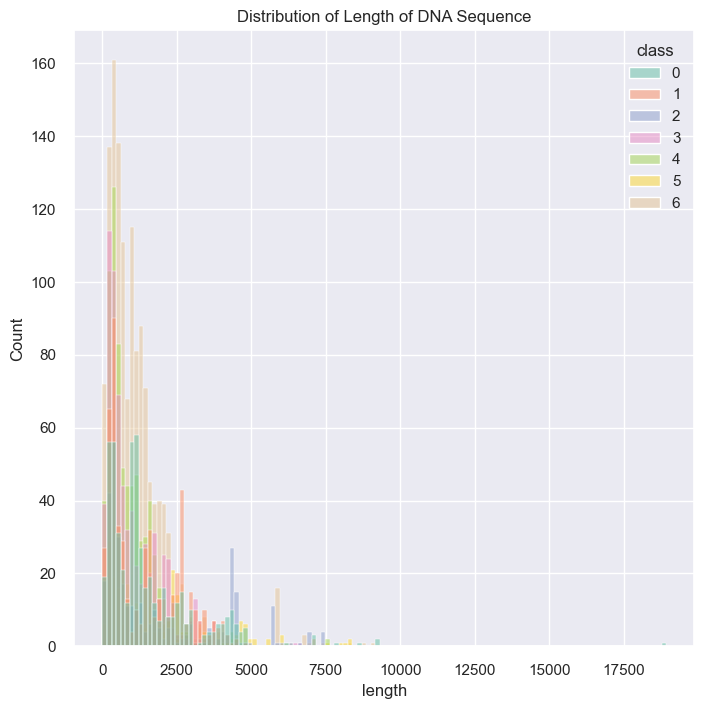

In [147]:
plt.figure(figsize=(8,8));
#create histogram to visualize distribution of length by class
sns.histplot(data=human_data, x='length', hue='class', palette = "Set2")
plt.title("Distribution of Length of DNA Sequence");

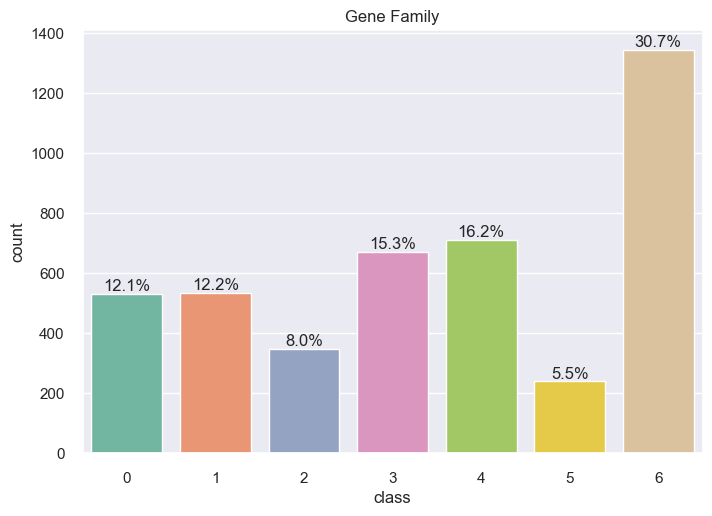

In [148]:
## 4380 Sequences are there
# We got an imbalanced classes situation with this dataset.

# get the total count of the type column
total = human_data['class'].count()

ax=sns.countplot(human_data, x="class", palette = "Set2")
for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f'{(x/total)*100:0.1f}%') 
plt.title("Gene Family")
plt.show()

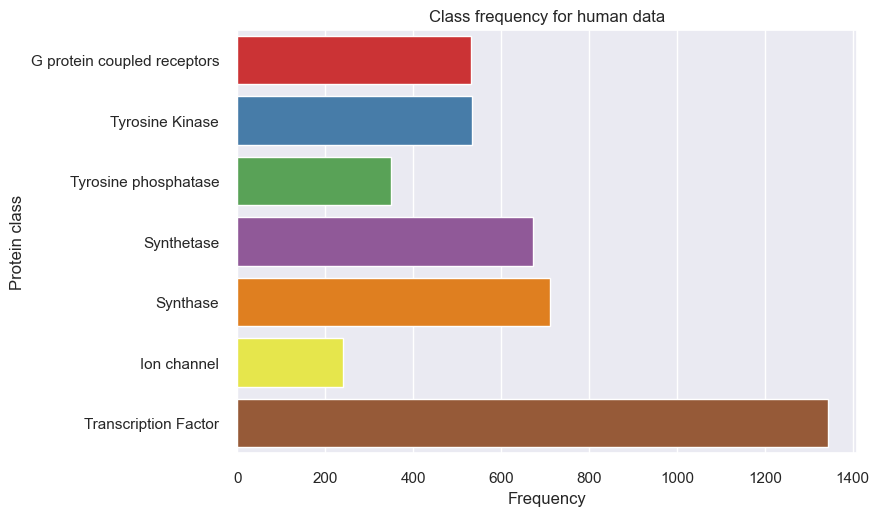

In [149]:
sns.barplot(x=human_data["class"].value_counts().sort_index(),y=labels, palette = "Set1") #plotting the barplot using seaborn 
plt.title("Class frequency for human data")
plt.xlabel('Frequency')
plt.ylabel('Protein class')
plt.show()

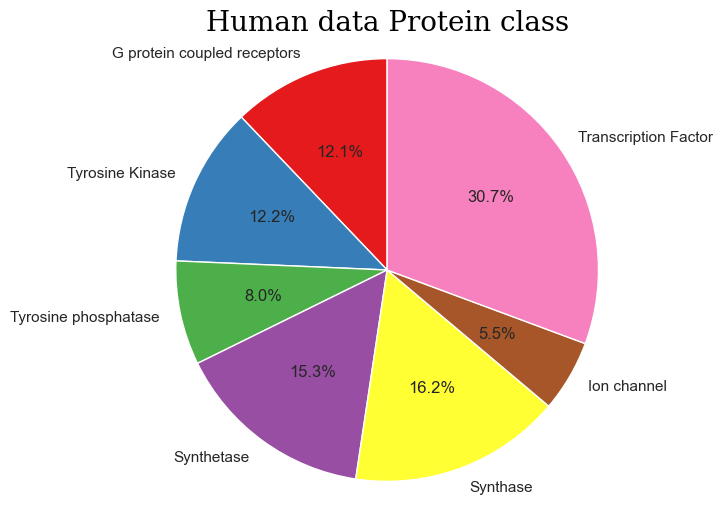

In [150]:
plt.figure(figsize=(6,6))
font_dict=font = {'family': 'serif', 
        'color':  'Black',
        'weight': 'normal',
        'size': 20,
        }
a=np.random.random(7)
cs=cm.Set1(np.arange(7)/7.)
plt.pie(human_data["class"].value_counts().sort_index(),labels=labels,autopct='%1.1f%%',colors=cs,startangle=90) 
plt.axis('equal')
plt.title("Human data Protein class",fontdict=font_dict) 
plt.show() #displaying the plot

# 3. Model Development 



# Human Data 

In [151]:
#k-mers are subsequences of length k {\displaystyle k} k contained within a biological sequence. Primarily used 
# within the context of computational genomics and sequence analysis, in which k-mers are composed of nucleotides 
# (i.e. A, T, G, and C), k-mers are capitalized upon to assemble DNA sequences,[1] improve heterologous gene 
# expression,[2][3] identify species in metagenomic samples,[4] and create attenuated vaccines.[5] Usually, the 
# term k-mer refers to all of a sequence's subsequences of length k {\displaystyle k} k, such that the sequence 
# AGAT would have four monomers (A, G, A, and T), three 2-mers (AG, GA, AT), two 3-mers (AGA and GAT) and one 4-mer 
# (AGAT).
# For example, if we use words of length 6 (hexamers), “ATGCATGCA” becomes: ‘ATGCAT’, ‘TGCATG’, ‘GCATGC’, ‘CATGCA’. 
# Hence our example sequence is broken down into 4 hexamer words.

# function to convert sequence strings into k-mer words

In [176]:
# takes a DataFrame with a string column and transforms it into a new DataFrame 
# where each row contains the k-mer frequency dictionaries for the corresponding string in the original DataFrame.
# it uses vectorized operations provided by pandas to calculate k-mer frequencies. 

from joblib import Parallel, delayed

def kmer_frequencies(sequence, k):
    kmers = [''.join(mer) for mer in zip(*[sequence[i:] for i in range(k)])]
    kmer_counts = pd.Series(kmers).value_counts(normalize=True).to_dict()
    return kmer_counts

def process_sequence(sequence, k):
    return kmer_frequencies(sequence, k)

def KMerTransformer(df, column_name, k, n_jobs=-1):
    sequences = df[column_name]
    results = Parallel(n_jobs=n_jobs)(delayed(process_sequence)(seq, k) for seq in sequences)
    return pd.DataFrame(results).fillna(0)

In [153]:
KMerTransformer(human_data,'sequence', 4)

,AAAA,AAAT,CCCA,TAAA,CCCC,ACTA,ACCA,ATAA,TACC,CAAA,...,NGGT,NATG,NCGT,NTCT,NATT,NCGA,NTAC,NACG,NTAT,NGTC
0,0.044118,0.029412,0.029412,0.024510,0.024510,0.024510,0.019608,0.019608,0.019608,0.019608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.005900,0.007375,0.008850,0.004425,0.011799,0.013274,0.011799,0.004425,0.004425,0.005900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.004159,0.004753,0.004753,0.004159,0.001188,0.002377,0.004159,0.002971,0.002971,0.006536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.004156,0.004156,0.000831,0.004988,0.001663,0.000831,0.003325,0.003325,0.001663,0.005819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.004881,0.004184,0.005579,0.004881,0.001395,0.002789,0.003487,0.002789,0.003487,0.007671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,0.018519,0.000000,0.000000,0.000000,0.000000,0.018519,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4376,0.005952,0.004592,0.008163,0.002041,0.007483,0.002041,0.006463,0.001871,0.003571,0.006973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4377,0.006020,0.004644,0.008256,0.002064,0.006708,0.002064,0.006536,0.001892,0.003612,0.007052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4378,0.006667,0.005333,0.005333,0.001333,0.002667,0.001333,0.002667,0.000000,0.006667,0.005333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
kmer_matrix= pd.concat([KMerTransformer(human_data,'sequence', 4), human_data[['class']] ], axis=1)
kmer_matrix.head()

,AAAA,AAAT,CCCA,TAAA,CCCC,ACTA,ACCA,ATAA,TACC,CAAA,...,NATG,NCGT,NTCT,NATT,NCGA,NTAC,NACG,NTAT,NGTC,class
0,0.044118,0.029412,0.029412,0.024510,0.024510,0.024510,0.019608,0.019608,0.019608,0.019608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,0.005900,0.007375,0.008850,0.004425,0.011799,0.013274,0.011799,0.004425,0.004425,0.005900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.004159,0.004753,0.004753,0.004159,0.001188,0.002377,0.004159,0.002971,0.002971,0.006536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.004156,0.004156,0.000831,0.004988,0.001663,0.000831,0.003325,0.003325,0.001663,0.005819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.004881,0.004184,0.005579,0.004881,0.001395,0.002789,0.003487,0.002789,0.003487,0.007671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [155]:
RANDOM_SEED =123
#train, unseen = data_sampling(kmer_matrix, 0.9, RANDOM_SEED)

In [156]:
start = timer() 

automl_clf = setup(data = kmer_matrix, target = 'class', fix_imbalance = True, fix_imbalance_method=smote, 
                   train_size=0.8, data_split_shuffle=True, data_split_stratify=True,
                   use_gpu=True, session_id=RANDOM_SEED)

end =timer()
print("Time used with GPU: ",timedelta(seconds=end-start))

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

,Description,Value
0,Session id,123
1,Target,class
2,Target type,Multiclass
3,Original data shape,"(4380, 337)"
4,Transformed data shape,"(8394, 337)"
5,Transformed train set shape,"(7518, 337)"
6,Transformed test set shape,"(876, 337)"
7,Numeric features,336
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

In [157]:
start = timer() 

compare_models() 

print("Time used: ",timedelta(seconds=end-start))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8567,0.9801,0.8567,0.8662,0.8558,0.8224,0.8244,17.3730
et,Extra Trees Classifier,0.8562,0.9782,0.8562,0.8675,0.8553,0.8210,0.8242,1.3810
xgboost,Extreme Gradient Boosting,0.8542,0.9788,0.8542,0.8591,0.8531,0.8197,0.8210,7.5480
rf,Random Forest Classifier,0.8425,0.9736,0.8425,0.8539,0.8414,0.8040,0.8070,2.0010
knn,K Neighbors Classifier,0.8236,0.9592,0.8236,0.8558,0.8275,0.7891,0.7941,1.0980
gbc,Gradient Boosting Classifier,0.7914,0.9510,0.7914,0.7952,0.7911,0.7435,0.7442,303.7210
lda,Linear Discriminant Analysis,0.6652,0.8834,0.6652,0.6874,0.6699,0.5969,0.5992,1.1130
dt,Decision Tree Classifier,0.6441,0.7864,0.6441,0.6529,0.6455,0.5682,0.5692,2.6610
ridge,Ridge Classifier,0.5185,0.0000,0.5185,0.5608,0.5105,0.4210,0.4284,0.9800
ada,Ada Boost Classifier,0.4609,0.7777,0.4609,0.4721,0.4600,0.3507,0.3527,9.8900


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=123, reg_alpha=0.0, reg_lambda=0.0,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

    The grid by default is sorted using 'Accuracy' (highest to lowest) which can be changed by passing the sort parameter. For example compare_models(sort = 'Recall') will sort the grid by Recall instead of Accuracy. If you want to change the fold parameter from the default value of 10 to a different value then you can use the fold parameter. Reducing the number of folds will improve the training time.

    https://www.pycaret.org/tutorials/html/MCLF101.html

### Creating the Model

In [158]:
# Extra Trees Classifier
model_et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8490,0.9773,0.8490,0.8581,0.8483,0.8130,0.8146
1,0.8803,0.9866,0.8803,0.8917,0.8791,0.8511,0.8544
2,0.8661,0.9823,0.8661,0.8799,0.8650,0.8331,0.8380
3,0.8604,0.9780,0.8604,0.8700,0.8596,0.8265,0.8294
4,0.8714,0.9859,0.8714,0.8790,0.8710,0.8406,0.8426
5,0.8657,0.9771,0.8657,0.8764,0.8657,0.8331,0.8359
6,0.8514,0.9757,0.8514,0.8678,0.8516,0.8144,0.8192
7,0.8371,0.9694,0.8371,0.8517,0.8374,0.7966,0.8006
8,0.8343,0.9703,0.8343,0.8473,0.8328,0.7935,0.7964


In [ ]:
#trained model object is stored in the variable 'model_rf'. 
print(model_et)

### Evaluating the Model

In [160]:
evaluate_model(model_et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Tune a Model

In [161]:
tuned_et = tune_model(model_et, optimize='F1', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6980,0.9131,0.6980,0.7162,0.6935,0.6324,0.6357
1,0.7037,0.9274,0.7037,0.7322,0.7065,0.6396,0.6425
2,0.7009,0.9260,0.7009,0.7170,0.6967,0.6333,0.6368
3,0.7379,0.9304,0.7379,0.7556,0.7372,0.6795,0.6820
4,0.7114,0.9301,0.7114,0.7233,0.7117,0.6470,0.6484
5,0.7029,0.9143,0.7029,0.7297,0.7058,0.6399,0.6429
6,0.6371,0.8980,0.6371,0.6533,0.6357,0.5569,0.5595
7,0.6543,0.8957,0.6543,0.6762,0.6552,0.5777,0.5799
8,0.6943,0.9220,0.6943,0.7046,0.6928,0.6272,0.6292


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [177]:
# The tuned model doesn't get any improvement, so the base model is the best.
# Time to build a Bagging Ensemble.

bagged_model = ensemble_model(tuned_et, optimize="F1", method = 'Bagging') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8661,0.9800,0.8661,0.8850,0.8656,0.8327,0.8378
1,0.8803,0.9867,0.8803,0.8893,0.8787,0.8513,0.8543
2,0.8661,0.9849,0.8661,0.8887,0.8670,0.8324,0.8397
3,0.8832,0.9835,0.8832,0.8977,0.8836,0.8546,0.8585
4,0.8714,0.9862,0.8714,0.8809,0.8709,0.8402,0.8429
5,0.8600,0.9822,0.8600,0.8726,0.8589,0.8256,0.8293
6,0.8429,0.9777,0.8429,0.8668,0.8434,0.8026,0.8107
7,0.8543,0.9768,0.8543,0.8701,0.8531,0.8174,0.8232
8,0.8571,0.9809,0.8571,0.8674,0.8550,0.8220,0.8249


In [163]:
#  Boosting Ensemble.
boosted_model = ensemble_model(tuned_et, optimize="F1", method="Boosting") 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8632,0.9738,0.8632,0.8760,0.8624,0.8300,0.8328
1,0.8718,0.9807,0.8718,0.8855,0.8697,0.8402,0.8442
2,0.8718,0.9798,0.8718,0.8934,0.8723,0.8397,0.8462
3,0.8860,0.9835,0.8860,0.8989,0.8864,0.8585,0.8616
4,0.8800,0.9824,0.8800,0.8879,0.8798,0.8511,0.8532
5,0.8571,0.9802,0.8571,0.8649,0.8564,0.8231,0.8247
6,0.8371,0.9676,0.8371,0.8533,0.8374,0.7965,0.8017
7,0.8429,0.9685,0.8429,0.8540,0.8429,0.8041,0.8076
8,0.8371,0.9762,0.8371,0.8453,0.8355,0.7973,0.7999


In [164]:
# The Bagged Model is the best and is saved as the best model and used to predict on the test set.

best_model = bagged_model

In [ ]:
# Blend Models

#best_recall_models_top3 = compare_models(sort='Recall', n_select=3)

# blend top 3 models  # help(blend_models)
#blend_models(best_recall_models_top3)

# stack models   # help(stack_models)
#stack_models(best_recall_models_top3)


### Plot a Model

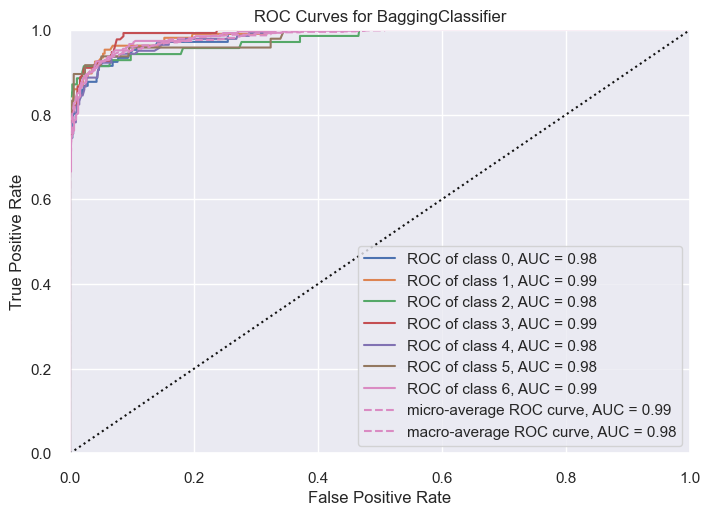

In [165]:
plot_model(best_model, plot="auc") # plot the AUC Score.

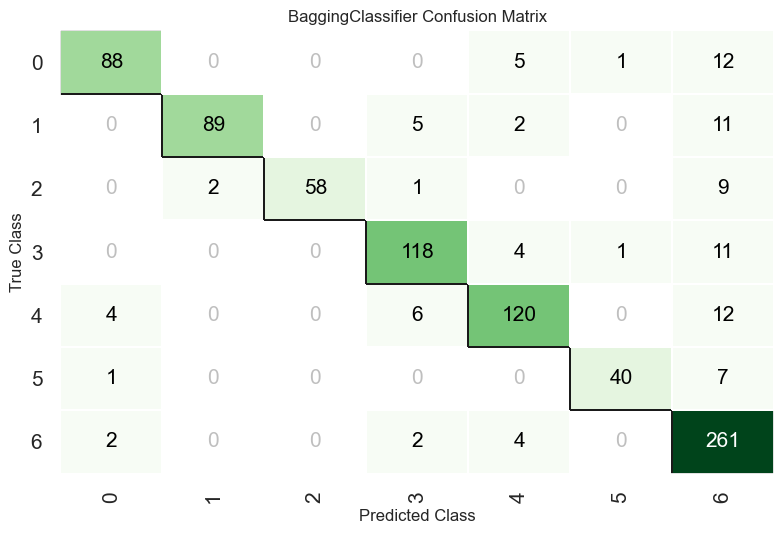

In [166]:
plot_model(best_model, plot = 'confusion_matrix')  #Confusion Matrix

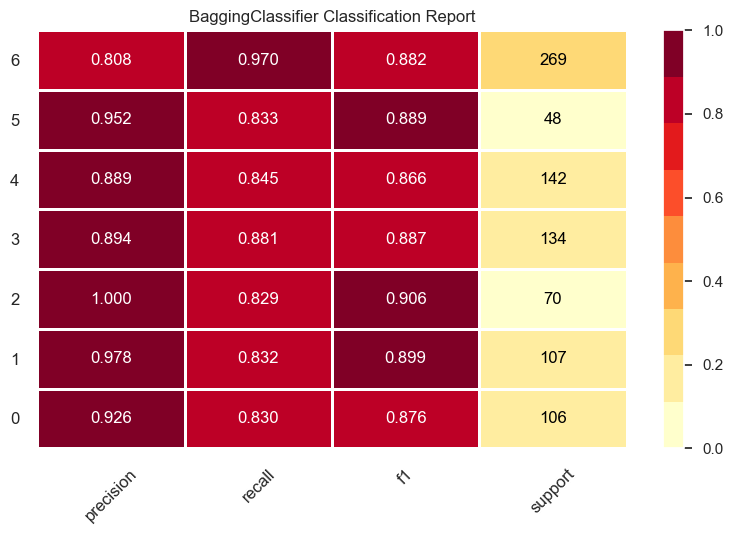

In [167]:
plot_model(best_model, plot = 'class_report') # Classification Report

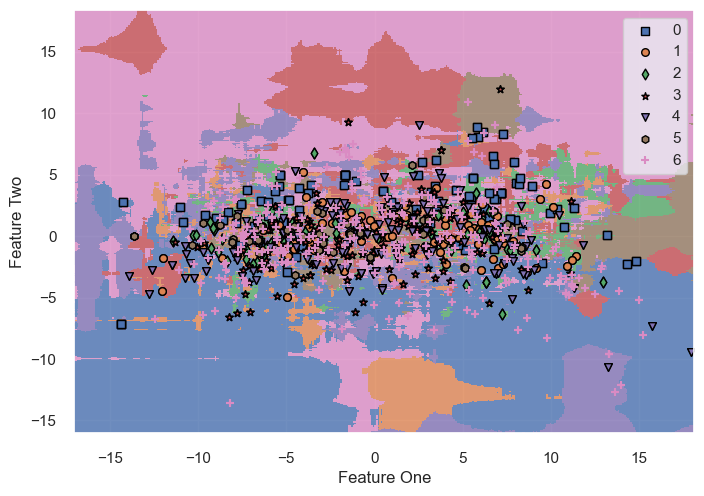

In [168]:
plot_model(best_model, plot='boundary') # Decision Boundary Plot

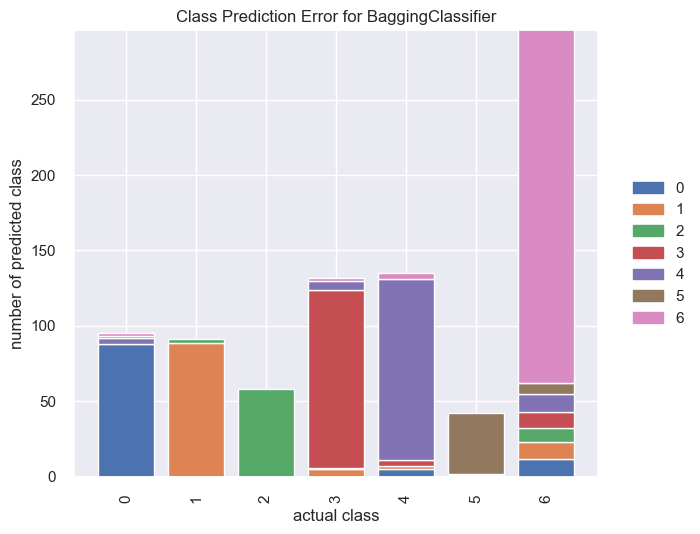

In [169]:
plot_model(best_model, plot = 'error') # Prediction Error Plot

### Predict on test / hold-out Sample

In [170]:
predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8836,0.9858,0.8836,0.8926,0.8838,0.8554,0.8579


,AAAA,AAAT,CCCA,TAAA,CCCC,ACTA,ACCA,ATAA,TACC,CAAA,...,NTCT,NATT,NCGA,NTAC,NACG,NTAT,NGTC,class,prediction_label,prediction_score
2342,0.000000,0.000000,0.008121,0.000000,0.008121,0.000000,0.003480,0.000000,0.004640,0.001160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,1.000
3305,0.002392,0.000000,0.011962,0.000000,0.004785,0.000000,0.009569,0.000000,0.004785,0.009569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4,0.504
4375,0.018519,0.000000,0.000000,0.000000,0.000000,0.018519,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6,0.332
3533,0.000658,0.000000,0.008558,0.000000,0.012508,0.001317,0.003950,0.000000,0.004608,0.000658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.263
2956,0.002011,0.002011,0.014580,0.000000,0.014077,0.004525,0.009050,0.001006,0.005028,0.004525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,0.842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655,0.000971,0.000647,0.010680,0.000000,0.010680,0.001294,0.005178,0.000647,0.002589,0.002589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.941
1393,0.014276,0.007138,0.004283,0.004283,0.003569,0.000714,0.002855,0.002141,0.000714,0.011420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,0.453
149,0.000000,0.000000,0.004149,0.000000,0.008299,0.000000,0.004149,0.008299,0.004149,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4,0.752
4086,0.007455,0.007455,0.002130,0.005325,0.000000,0.002130,0.005325,0.001065,0.002130,0.010650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4,0.249


### Finalize Model for Deployment

In [171]:
#Final parameters for deployment

# final_model = finalize_model(best_model)
# print(final_model)

**Caution**: One final word of caution. Once the model is finalized using finalize_model(), the entire dataset including the test/hold-out set is used for training. As such, if the model is used for predictions on the hold-out set after finalize_model() is used, the information grid printed will be misleading as you are trying to predict on the same data that was used for modeling. In order to demonstrate this point only, we will use 'final_et' under predict_model() to compare the information grid with the one above

In [172]:
# predict_model(final_et); # all of the metrics for final_et are now set to a perfect 1.000. This is because the final_et variable is trained on the complete dataset including the test/hold-out set.

In [173]:
# save_model(final_et,'Final_et_Model2024')

In [174]:
# saved_final_et = load_model('Final_et_Model2024')

In [175]:
# unseen_predictions = predict_model(saved_final_et, data=data_unseen)
# unseen_predictions.head()

# CONCLUSION - 
By Using PyCaret,  we obtained the maximum accuracy with *Extra Trees Classifier* on k-mer words (k=4) with AUC around 98% 

### Reference
    https://ernest-bonat.medium.com/apply-machine-learning-algorithms-for-genomics-data-classification-132972933723
    https://www.kaggle.com/code/nageshsingh/demystify-dna-sequencing-with-machine-learning
    https://www.kaggle.com/code/bulentsiyah/classifying-dna-sequences-markov-models-knn-svm
    https://www.kaggle.com/code/sooryaprakash12/intro-to-gene-classification-from-dna-sequence
    https://medium.com/@rollingstorms/dna-sequence-classification-for-species-prediction-df202bcb621f

#### PyCaret    
    https://www.kaggle.com/code/pralabhpoudel/multiclass-classification-with-automl-pycaret
    https://pycaret.gitbook.io/docs/get-started/preprocessing/data-preparation
    https://www.kaggle.com/code/rhythmcam/pycaret-fix-imbalance-deal-with-unbalanced-data
    https://towardsdatascience.com/write-and-train-your-own-custom-machine-learning-models-using-pycaret-8fa76237374e
    https://www.pycaret.org/tutorials/html/MCLF101.html
    https://nbviewer.org/github/pycaret/examples/blob/main/PyCaret%202%20Text%20Similarity%20Classification.ipynb
    https://towardsdatascience.com/build-your-own-automl-in-power-bi-using-pycaret-8291b64181d
    https://pycaret.gitbook.io/docs/get-started/quickstart#setup
    https://github.com/pycaret/pycaret/blob/master/tutorials/Tutorial%20-%20Multiclass%20Classification.ipynb
    https://blog.csdn.net/qq_42034590/article/details/130407102

### AutoML
    https://levelup.gitconnected.com/10-python-libraries-for-automated-machine-learning-that-you-should-think-to-use-in-2023-730a2694f221
    https://cruizbran.medium.com/auto-ml-4b17e52d7a80
    https://www.analyticsvidhya.com/blog/2022/02/auto-sklearn-accelerate-your-machine-learning-models-with-automl/
    https://www.automl.org/automl/
    https://www.simonwenkel.com/notes/software_libraries/auto-sklearn/Introduction-to-auto-sklearn.html#classification-example